![](https://www.domsoria.com/wp-content/uploads/2019/11/keras.png)

# Deep Neural Network optimisation

We will build a deep network, and study several optimisation methods to avoid overfit and other issues affecting deep learning applications. 

**After this assignment you will be able to:**
- Build and apply a deep neural network to supervised learning, having a method to understand and face issues.

Let's get started!

In [1]:
# Import libraries
import time
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from utils.dnn_app_utils_v3 import *
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import Normalizer, OneHotEncoder

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, Dropout
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
import pydot
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from utils.resnets_utils import *
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2
import scipy.misc
from matplotlib.pyplot import imshow

import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')

import skimage
import imageio

%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (10, 15) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(7)

### The Dataset


In [2]:
# generate 2d classification dataset
X, Y = make_moons(n_samples=150, noise=0.2, random_state=42)

X_train, X_test, Y_train_orig, Y_test_orig = train_test_split(X, Y, test_size=0.2)

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 2).T
Y_test = convert_to_one_hot(Y_test_orig, 2).T

print("number of training examples = " + str(X_train.shape[0]))
print("number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))

number of training examples = 120
number of test examples = 30
X_train shape: (120, 2)
Y_train shape: (120, 2)
X_test shape: (30, 2)
Y_test shape: (30, 2)


Just for sake of clariness, let's plot our dataset

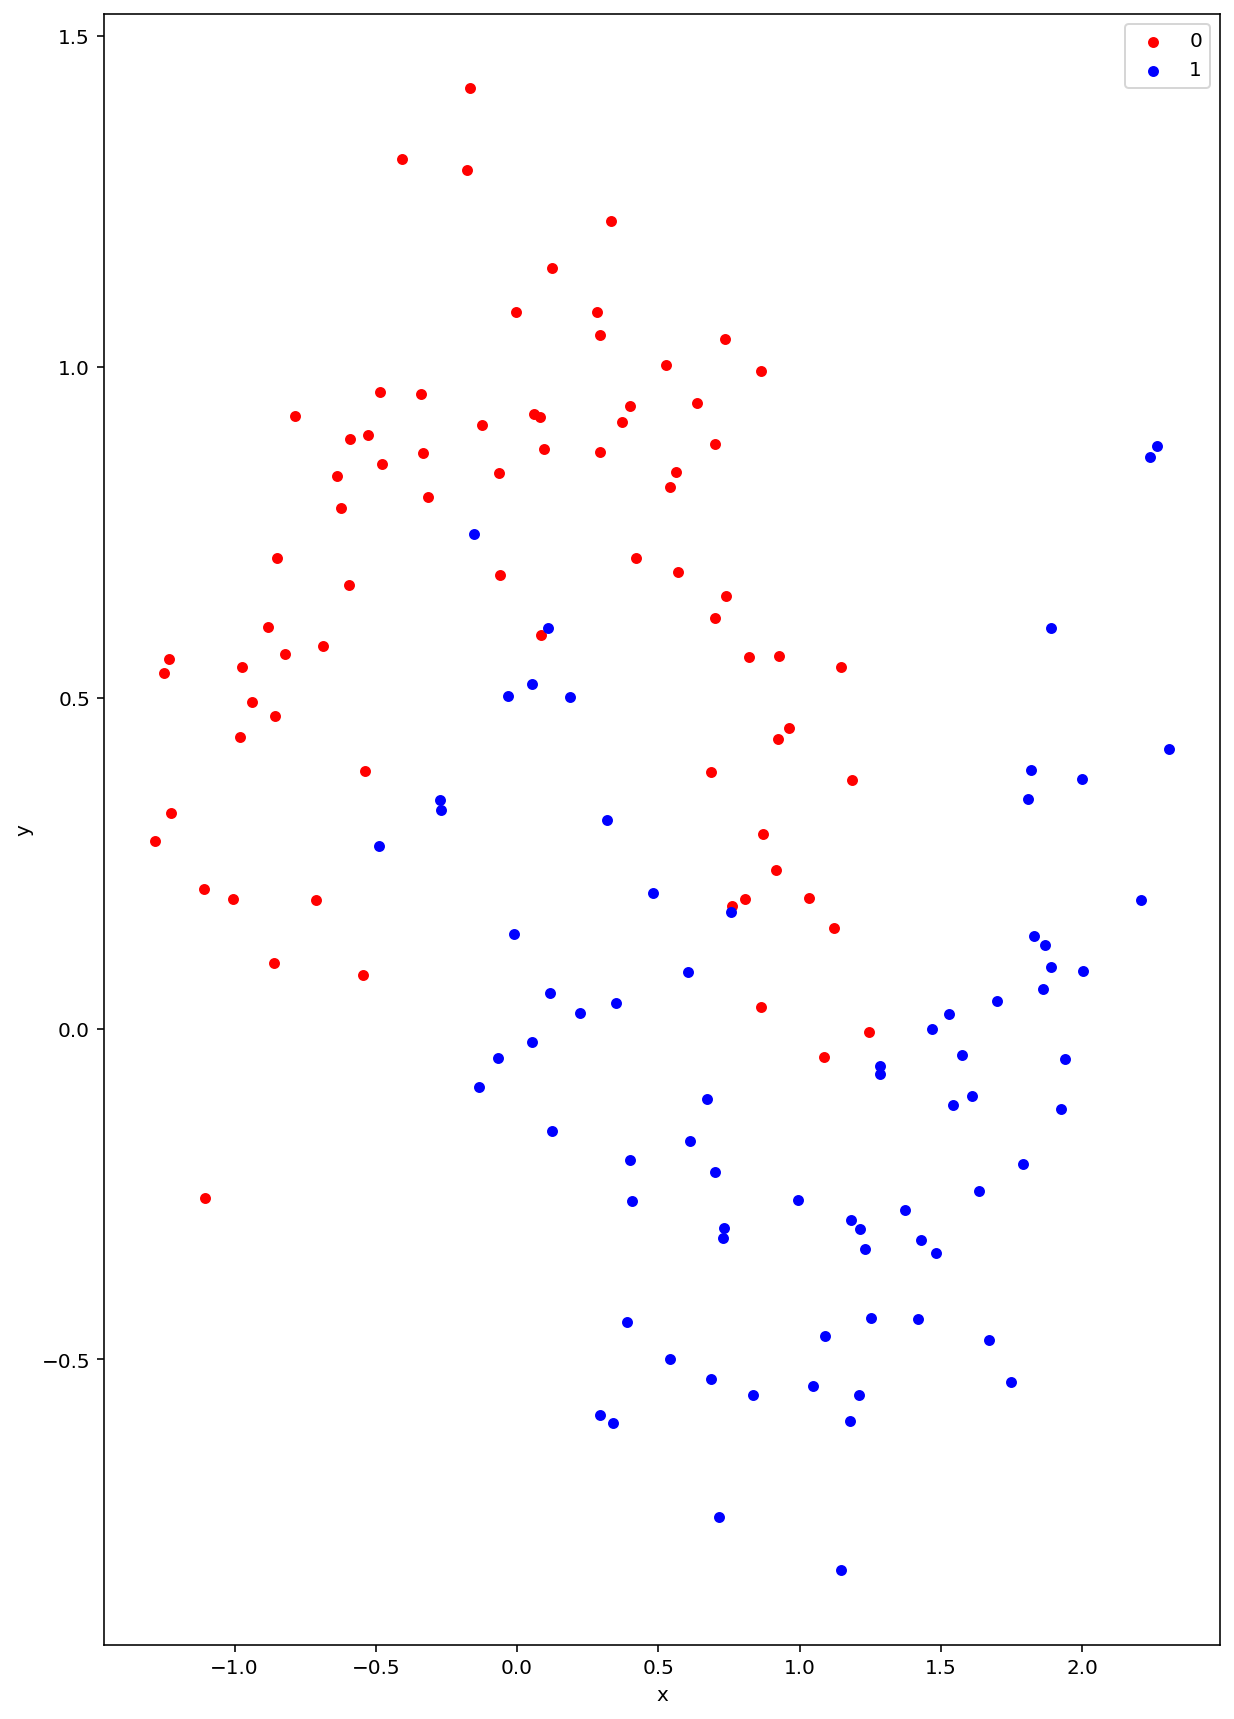

In [3]:
# scatter plot, dots colored by class value
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

Notice how the dataset cannot be separated by a line, so a Neural Network, being highly non linear may be what we need for this task.

## The model

Build a 3-Dense layer model

_DENSE -> RELU -> DENSE -> RELU -> DENSE -> SIGMOID_

and units: `1024` -> `512` -> `2`

In [4]:
# model building
n_x = X_train.shape[1] # number of features
model = Sequential()
model.add(Dense(1024, input_dim = n_x, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

opt = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              3072      
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 528,898
Trainable params: 528,898
Non-trainable params: 0
_________________________________________________________________


2022-06-28 10:27:51.062669: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-28 10:27:51.062796: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# fit model
history = model.fit(X_train, Y_train, epochs=2000, validation_split=0.3,shuffle=True)

Epoch 1/2000


2022-06-28 10:27:51.945655: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-28 10:27:52.129072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 205ms/step - loss: 0.6958 - accuracy: 0.3929 - val_loss: 0.6797 - val_accuracy: 0.7778
Epoch 2/2000


2022-06-28 10:27:53.216147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 20ms/step - loss: 0.6768 - accuracy: 0.7143 - val_loss: 0.6628 - val_accuracy: 0.8056
Epoch 3/2000
3/3 [==============================] - 0s 19ms/step - loss: 0.6607 - accuracy: 0.7500 - val_loss: 0.6472 - val_accuracy: 0.8056
Epoch 4/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.6445 - accuracy: 0.7619 - val_loss: 0.6332 - val_accuracy: 0.8333
Epoch 5/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.6305 - accuracy: 0.7619 - val_loss: 0.6198 - val_accuracy: 0.8333
Epoch 6/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.6160 - accuracy: 0.7619 - val_loss: 0.6074 - val_accuracy: 0.8333
Epoch 7/2000
3/3 [==============================] - 0s 14ms/step - loss: 0.6034 - accuracy: 0.7619 - val_loss: 0.5955 - val_accuracy: 0.8333
Epoch 8/2000
3/3 [==============================] - 0s 14ms/step - loss: 0.5910 - accuracy: 0.7619 - val_loss: 0.5841 - val_accuracy: 0.8056
Epoch 9/2000
3/3 [========

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


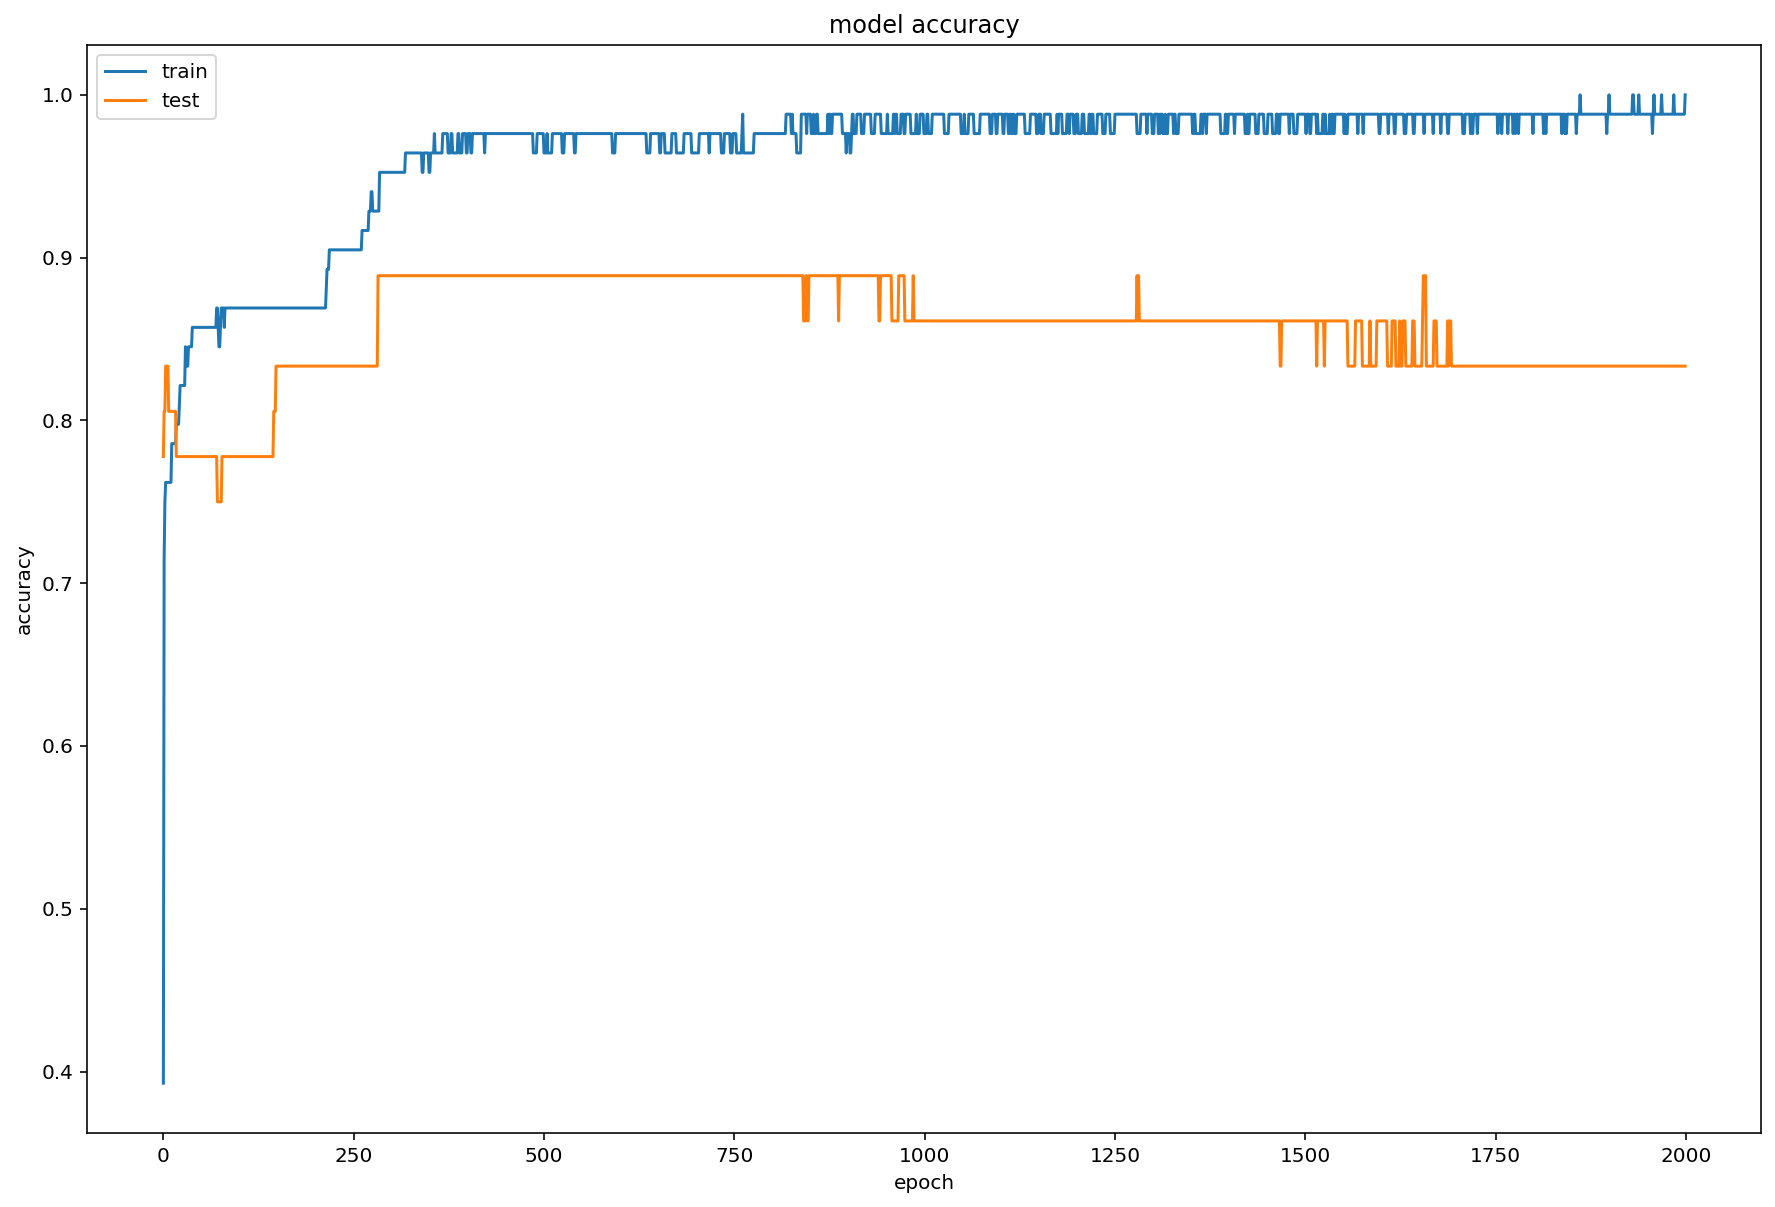

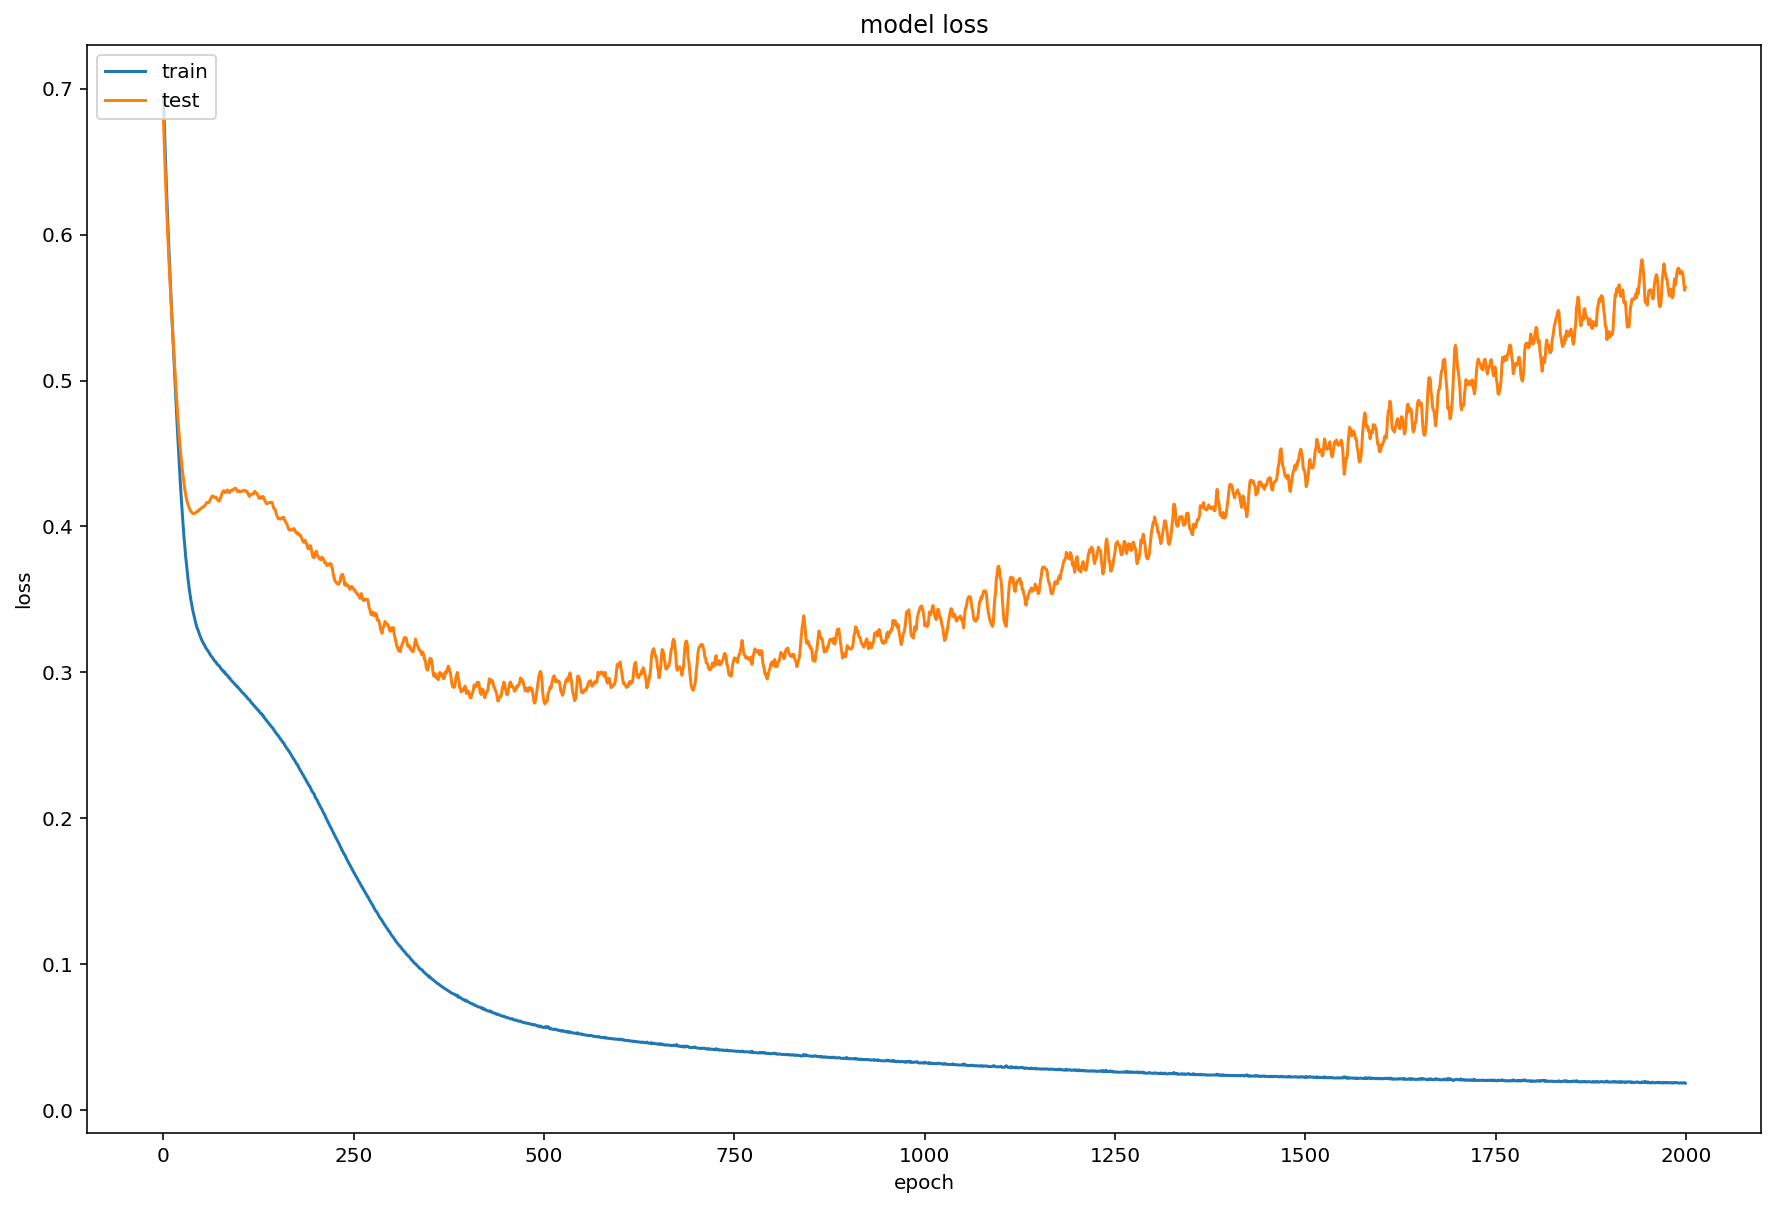

In [6]:
print(history.history.keys())

plt.figure(figsize=(15,10))

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(15,10))
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
train_metr = model.evaluate(X_train, Y_train, verbose=0)
results = model.evaluate(X_test, Y_test, verbose=0)

print(f'Training {model.metrics_names[0]}: {train_metr[0]} \nTraining {model.metrics_names[1]}: {train_metr[1]}' )
print('='*35)
print(f'Test {model.metrics_names[0]}: {results[0]} \nTest {model.metrics_names[1]}: {results[1]}' )

Training loss: 0.18204697966575623 
Training accuracy: 0.9500000476837158
Test loss: 0.4540025591850281 
Test accuracy: 0.9666666984558105


We can see that the model has better performance on the training dataset than the test dataset, one possible sign of __overfitting__.

Let's plot decision boundaries to have a clearer picture

In [8]:
def plot_decision_boundary(X, y, model, steps=1000, cmap='Paired'):
    cmap = plt.get_cmap(cmap)

    # Define region of interest by data limits
    xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
    ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    labels = np.argmax(model.predict(np.c_[xx.ravel(), yy.ravel()]), axis=-1)

    
    # Plot decision boundary in region of interest
    z = labels.reshape(xx.shape)

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=cmap, alpha=0.5)

    # Get predicted labels on training data and plot
    train_labels = model.predict(X)
    ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, lw=0)

    return fig, ax

   89/31250 [..............................] - ETA: 53s

2022-06-28 10:29:20.559864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 3ms/step


2022-06-28 10:30:39.547134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


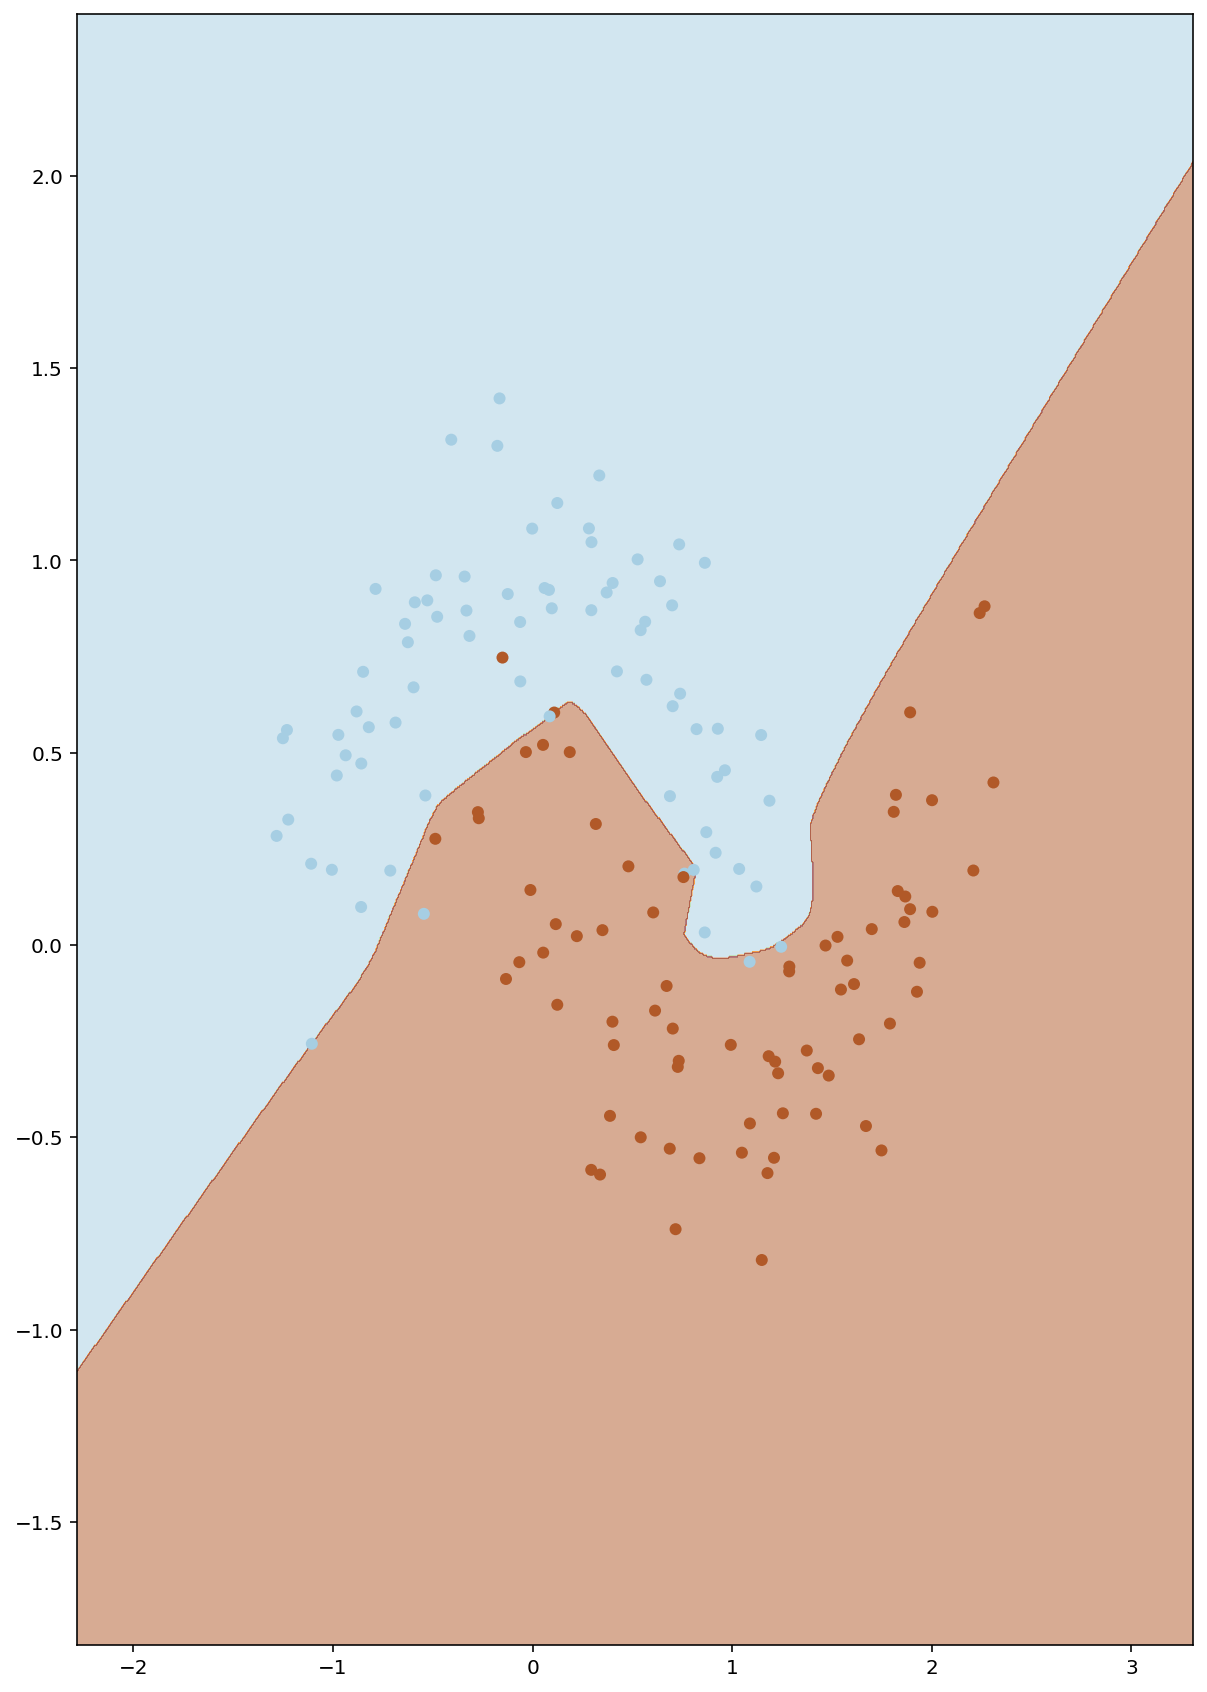

In [9]:
plot_decision_boundary(X, Y, model, steps=1000, cmap='Paired');

A much nicer figure (😉) can be seen [here](https://jamboard.google.com/d/1UmIdOUFZoUcjpPSOq_ryOyAjj5Houy87a--YxZSNi2g/edit?usp=sharing).

## The crucial question

> How do we fight overfit?

## Regularisation

As we have seen above, by an example, a central problem in machine learning is how to make an algorithm that will perform well not just on the training data, but also on new inputs. 
Many strategies used in machine learning are explicitly designed to reduce the test error, possibly at the expense of increased training error. These strategies are known collectively as _regularization_.

### Penalties

One of the most simple way to reduce overfit is to add a penalty term to the cost function.
Euristically, this _penalises_ the high-valued terms, reducing parameters' magnitude (each single node weight) and "simplifying" the model.

$$ J(\beta) = \frac{1}{n} \sum_k \mathcal{L}(\hat{y}^{(k)}, {y}^{(k)}) + \frac{\lambda}{p n} \Vert \beta \Vert_p^p $$

### Dropout

![](https://cdn-images-1.medium.com/max/1000/0*ZRRL-z_7ZxWpuryM.gif)

In a neural network, while training, we set a probability (can be different for each layer) of deleting some of the units of the layer. If $p = 1/2$, at each step we train the network on half of the units.
The guide principle is 
> _a smaller network is less prone to overfit_.

### Data augmentation

Another technique, really used in computer vision is _data augmentation_. 

With this, we mean a slight transformation of each training example (rotation, change of colour, blur, etc.) in order to have much more data and let the deep learning algorithm to have more experience of what an object is.

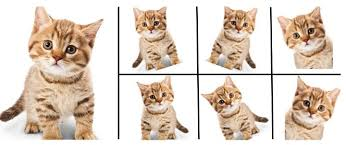

## Application: a guided exercise

We will use a famous dataset about a glass classification problem.

We have data about glass chemical compositions and we want to classify the type of glass.

Here the description of the dataset

__Attribute Information__:

* Id number: 1 to 214
* RI: refractive index
* Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
* Mg: Magnesium
* Al: Aluminum
* Si: Silicon
* K: Potassium
* Ca: Calcium
* Ba: Barium
* Fe: Iron
* Type of glass: (class attribute)
   1. building_windows_float_processed
   2. building_windows_non_float_processed
   3. vehicle_windows_float_processed
   4. vehicle_windows_non_float_processed (none in this database)
   5. containers
   6. tableware
   7. headlamps

The following cell loads the dataset.

In [10]:
# Loading the dataset
col_names = ['Id','RI','Na','Mg','Al','Si','K','Ca','Ba','Fe','Type']
df = pd.read_csv("datasets/glass.data", names=col_names, index_col='Id')
colsx = df.columns[:-1]
colsy = 'Type'

X = df[colsx]
X = X.values
Y = df[colsy].values
Y = Y.reshape(-1)

#### Some preprocessing

In [11]:
X = StandardScaler().fit_transform(X)

Y = np.eye(7)[Y - 1] # we have 7 classes = 7 types of glass

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

n_x = X_train.shape[1] # number of features
n_c = Y_train.shape[1] # number of classes

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 171
number of test examples = 43
X_train shape: (171, 9)
Y_train shape: (171, 7)
X_test shape: (43, 9)
Y_test shape: (43, 7)


In [12]:
# create model
model = Sequential()
model.add(Dense(10, kernel_initializer='normal',input_dim=n_x, activation='relu'))
model.add(Dense(n_c, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                100       
                                                                 
 dense_4 (Dense)             (None, 7)                 77        
                                                                 
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=300, validation_split=0.1,shuffle=True)

Epoch 1/300


2022-06-28 10:30:54.647464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 59ms/step - loss: 1.9170 - accuracy: 0.2353 - val_loss: 1.8805 - val_accuracy: 0.3889
Epoch 2/300
5/5 [==============================] - 0s 14ms/step - loss: 1.8978 - accuracy: 0.3007 - val_loss: 1.8689 - val_accuracy: 0.5000
Epoch 3/300
5/5 [==============================] - 0s 11ms/step - loss: 1.8798 - accuracy: 0.3529 - val_loss: 1.8572 - val_accuracy: 0.5000
Epoch 4/300
1/5 [=====>........................] - ETA: 0s - loss: 1.8731 - accuracy: 0.4375

2022-06-28 10:30:55.623275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 11ms/step - loss: 1.8625 - accuracy: 0.3791 - val_loss: 1.8454 - val_accuracy: 0.5556
Epoch 5/300
5/5 [==============================] - 0s 11ms/step - loss: 1.8449 - accuracy: 0.3922 - val_loss: 1.8323 - val_accuracy: 0.5556
Epoch 6/300
5/5 [==============================] - 0s 11ms/step - loss: 1.8269 - accuracy: 0.3856 - val_loss: 1.8187 - val_accuracy: 0.5556
Epoch 7/300
5/5 [==============================] - 0s 11ms/step - loss: 1.8087 - accuracy: 0.4118 - val_loss: 1.8037 - val_accuracy: 0.5556
Epoch 8/300
5/5 [==============================] - 0s 18ms/step - loss: 1.7914 - accuracy: 0.4118 - val_loss: 1.7888 - val_accuracy: 0.5556
Epoch 9/300
5/5 [==============================] - 0s 11ms/step - loss: 1.7722 - accuracy: 0.4183 - val_loss: 1.7733 - val_accuracy: 0.5000
Epoch 10/300
5/5 [==============================] - 0s 13ms/step - loss: 1.7536 - accuracy: 0.4248 - val_loss: 1.7578 - val_accuracy: 0.5000
Epoch 11/300
5/5 [=============

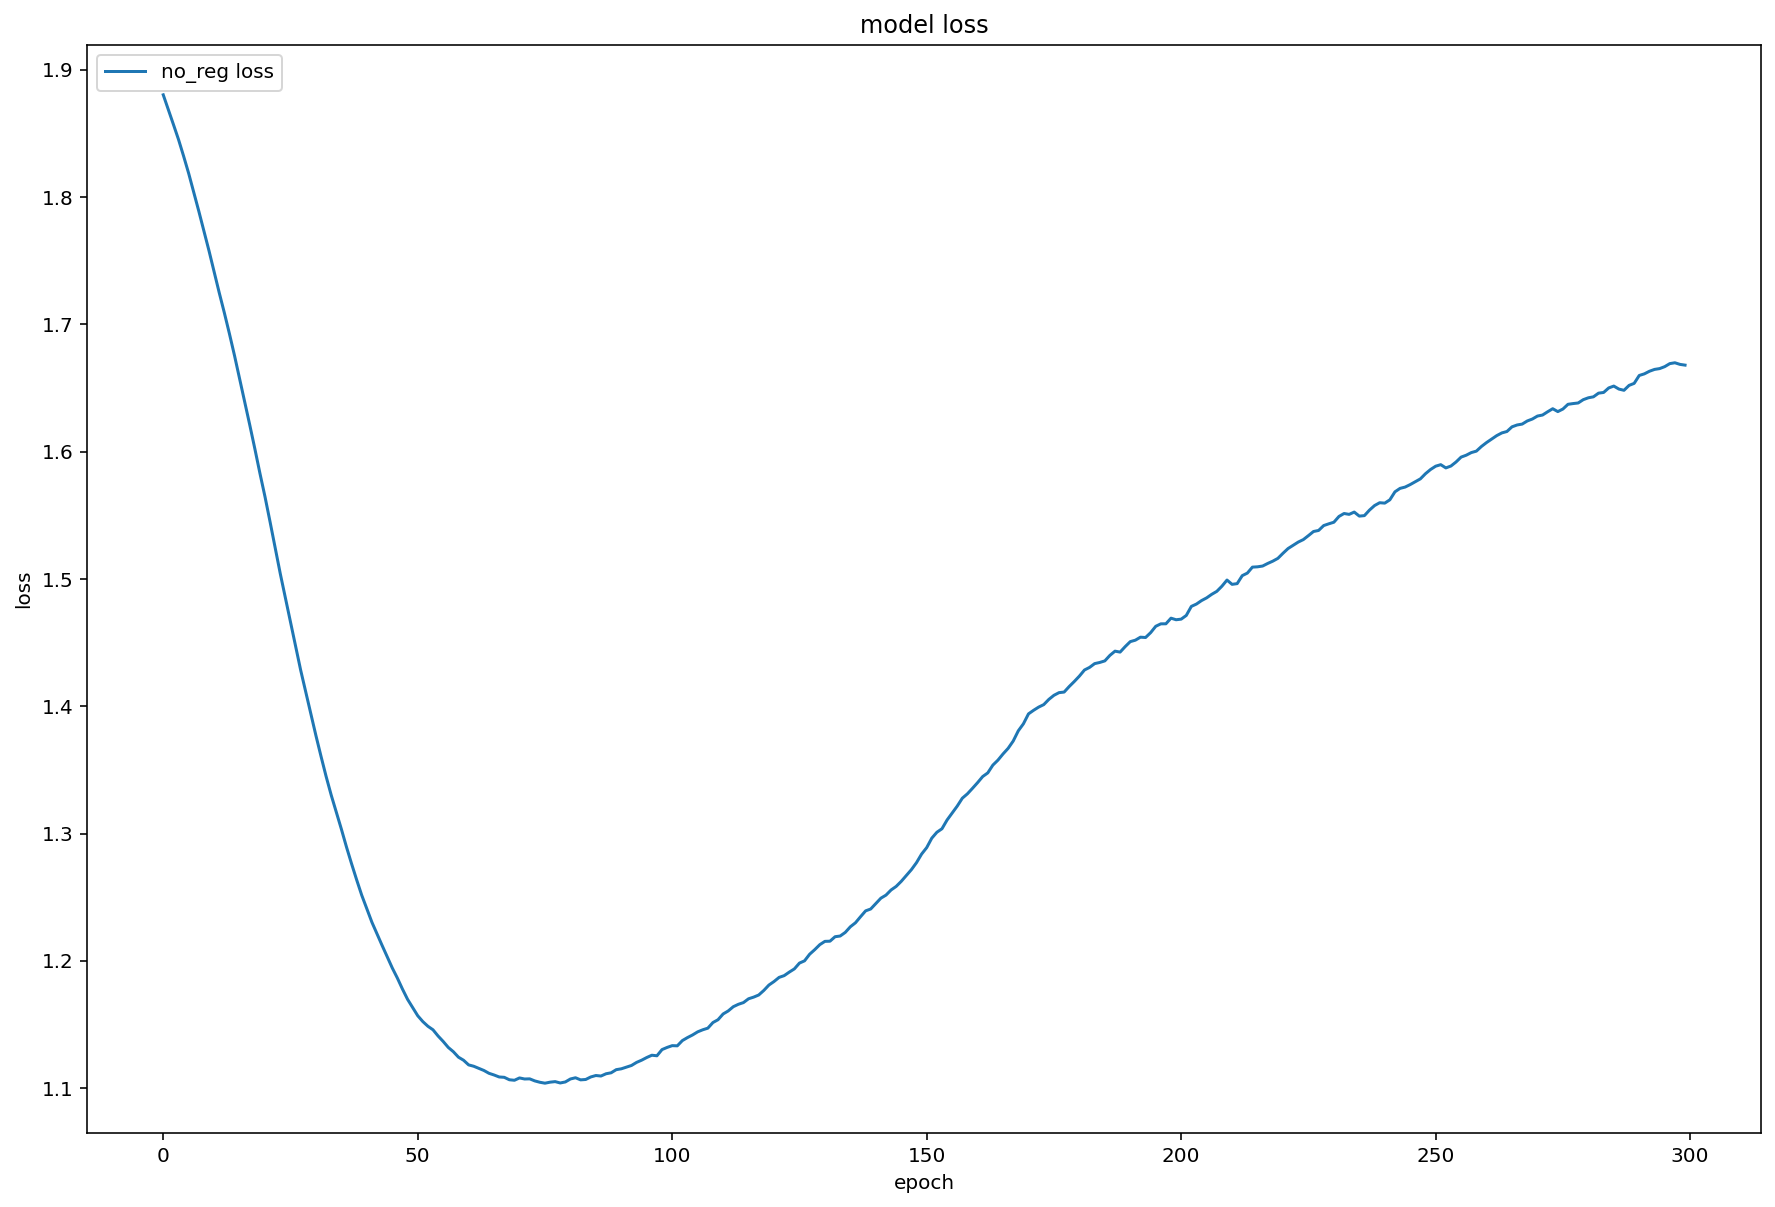

In [14]:
plt.figure(figsize=(15,10))
# summarize history for loss
#plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['no_reg loss'], loc='upper left')
plt.show()

In [15]:
results = model.evaluate(X_test, Y_test, verbose=0)

print(f'Test {model.metrics_names[0]}: {results[0]} \nTest {model.metrics_names[1]}: {results[1]}' )

Test loss: 0.6146448254585266 
Test accuracy: 0.7674418687820435


Let's see how to get better from this.

### Penalities

In [16]:
# create a model with a regularisation term
model_pen = Sequential()
model_pen.add(Dense(10, kernel_initializer='normal',input_dim=n_x, activation='relu',
                    kernel_regularizer= l2(0.01)))
model_pen.add(Dense(n_c, activation='softmax'))

model_pen.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
history_pen = model_pen.fit(X_train, Y_train, batch_size=32, epochs=300, validation_split=0.1,shuffle=True)

Epoch 1/300


2022-06-28 10:31:21.029115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 35ms/step - loss: 1.9088 - accuracy: 0.3203 - val_loss: 1.9308 - val_accuracy: 0.2778
Epoch 2/300
5/5 [==============================] - 0s 11ms/step - loss: 1.8878 - accuracy: 0.3529 - val_loss: 1.9130 - val_accuracy: 0.3889
Epoch 3/300
5/5 [==============================] - 0s 12ms/step - loss: 1.8686 - accuracy: 0.3529 - val_loss: 1.8973 - val_accuracy: 0.3889
Epoch 4/300
5/5 [==============================] - 0s 10ms/step - loss: 1.8496 - accuracy: 0.3660 - val_loss: 1.8822 - val_accuracy: 0.3333
Epoch 5/300


2022-06-28 10:31:21.348557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 15ms/step - loss: 1.8311 - accuracy: 0.3856 - val_loss: 1.8657 - val_accuracy: 0.3889
Epoch 6/300
5/5 [==============================] - 0s 10ms/step - loss: 1.8132 - accuracy: 0.4183 - val_loss: 1.8508 - val_accuracy: 0.3889
Epoch 7/300
5/5 [==============================] - 0s 10ms/step - loss: 1.7950 - accuracy: 0.4183 - val_loss: 1.8362 - val_accuracy: 0.3889
Epoch 8/300
5/5 [==============================] - 0s 10ms/step - loss: 1.7780 - accuracy: 0.4379 - val_loss: 1.8207 - val_accuracy: 0.4444
Epoch 9/300
5/5 [==============================] - 0s 10ms/step - loss: 1.7593 - accuracy: 0.4379 - val_loss: 1.8060 - val_accuracy: 0.4444
Epoch 10/300
5/5 [==============================] - 0s 11ms/step - loss: 1.7411 - accuracy: 0.4379 - val_loss: 1.7907 - val_accuracy: 0.4444
Epoch 11/300
5/5 [==============================] - 0s 11ms/step - loss: 1.7221 - accuracy: 0.4444 - val_loss: 1.7745 - val_accuracy: 0.4444
Epoch 12/300
5/5 [============

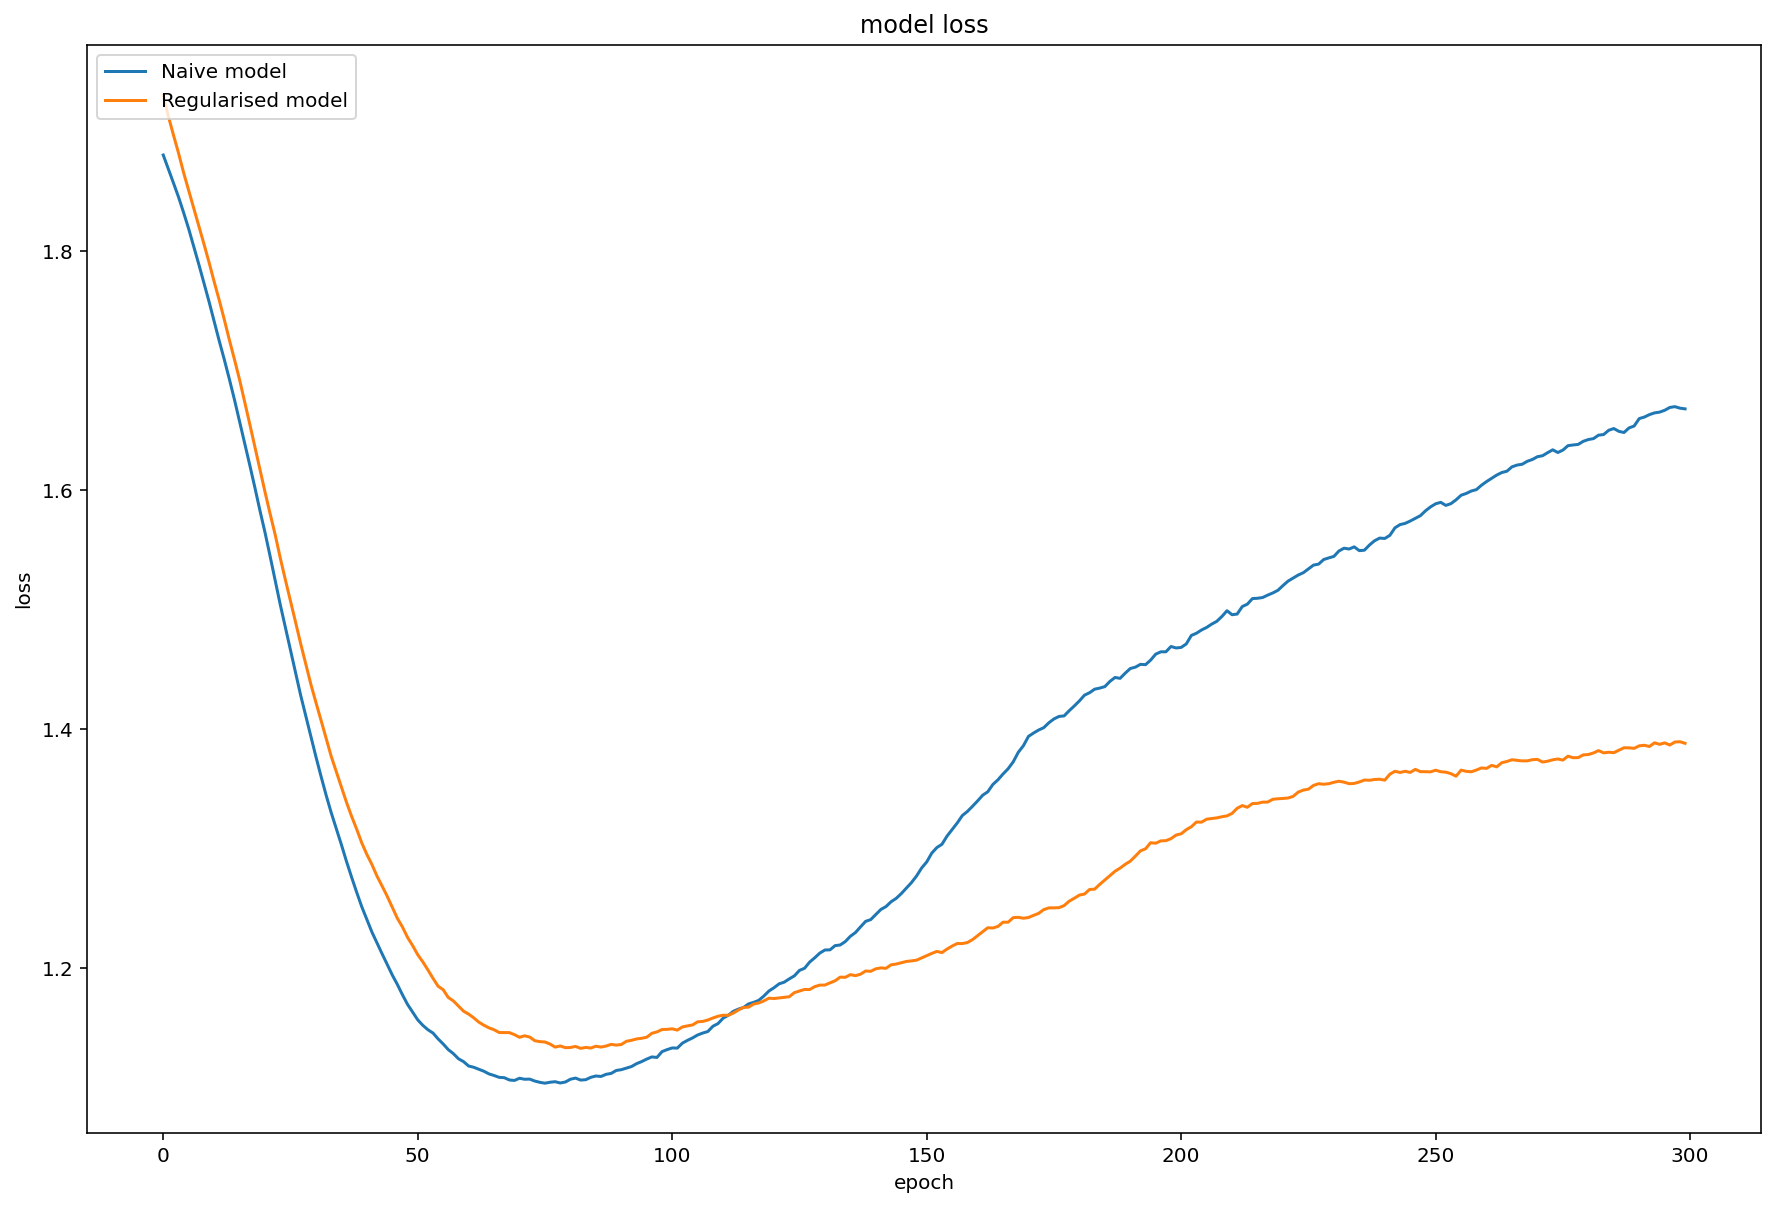

In [18]:
plt.figure(figsize=(15,10))
# summarize history for loss
#plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history_pen.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Naive model', 'Regularised model'], loc='upper left')
plt.show()

### Dropout

In [19]:
# create a model with a dropout layer 
model_drp = Sequential()
model_drp.add(Dense(10, kernel_initializer='normal',input_dim=n_x, activation='relu',
                    kernel_regularizer= l2(0.01)))
model_drp.add(Dropout(0.3))
model_drp.add(Dense(7, activation='relu'))
model_drp.add(Dense(n_c, activation='softmax'))

model_drp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
history_drp = model_drp.fit(X_train, Y_train, batch_size=32, epochs=300, validation_split=0.1,shuffle=True)

Epoch 1/300
1/5 [=====>........................] - ETA: 1s - loss: 1.9255 - accuracy: 0.2188

2022-06-28 10:31:43.369919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 40ms/step - loss: 1.9184 - accuracy: 0.2614 - val_loss: 1.8540 - val_accuracy: 0.3333
Epoch 2/300
5/5 [==============================] - 0s 12ms/step - loss: 1.9056 - accuracy: 0.3268 - val_loss: 1.8297 - val_accuracy: 0.5556
Epoch 3/300
5/5 [==============================] - 0s 11ms/step - loss: 1.8855 - accuracy: 0.3595 - val_loss: 1.8033 - val_accuracy: 0.5556
Epoch 4/300
1/5 [=====>........................] - ETA: 0s - loss: 1.8663 - accuracy: 0.3750

2022-06-28 10:31:43.635345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 14ms/step - loss: 1.8628 - accuracy: 0.4052 - val_loss: 1.7766 - val_accuracy: 0.5556
Epoch 5/300
5/5 [==============================] - 0s 13ms/step - loss: 1.8439 - accuracy: 0.3856 - val_loss: 1.7500 - val_accuracy: 0.5000
Epoch 6/300
5/5 [==============================] - 0s 11ms/step - loss: 1.8224 - accuracy: 0.3529 - val_loss: 1.7245 - val_accuracy: 0.5556
Epoch 7/300
5/5 [==============================] - 0s 11ms/step - loss: 1.7880 - accuracy: 0.3725 - val_loss: 1.6977 - val_accuracy: 0.5556
Epoch 8/300
5/5 [==============================] - 0s 11ms/step - loss: 1.7713 - accuracy: 0.3464 - val_loss: 1.6715 - val_accuracy: 0.5556
Epoch 9/300
5/5 [==============================] - 0s 11ms/step - loss: 1.7517 - accuracy: 0.3791 - val_loss: 1.6458 - val_accuracy: 0.5556
Epoch 10/300
5/5 [==============================] - 0s 11ms/step - loss: 1.7250 - accuracy: 0.3464 - val_loss: 1.6205 - val_accuracy: 0.5556
Epoch 11/300
5/5 [=============

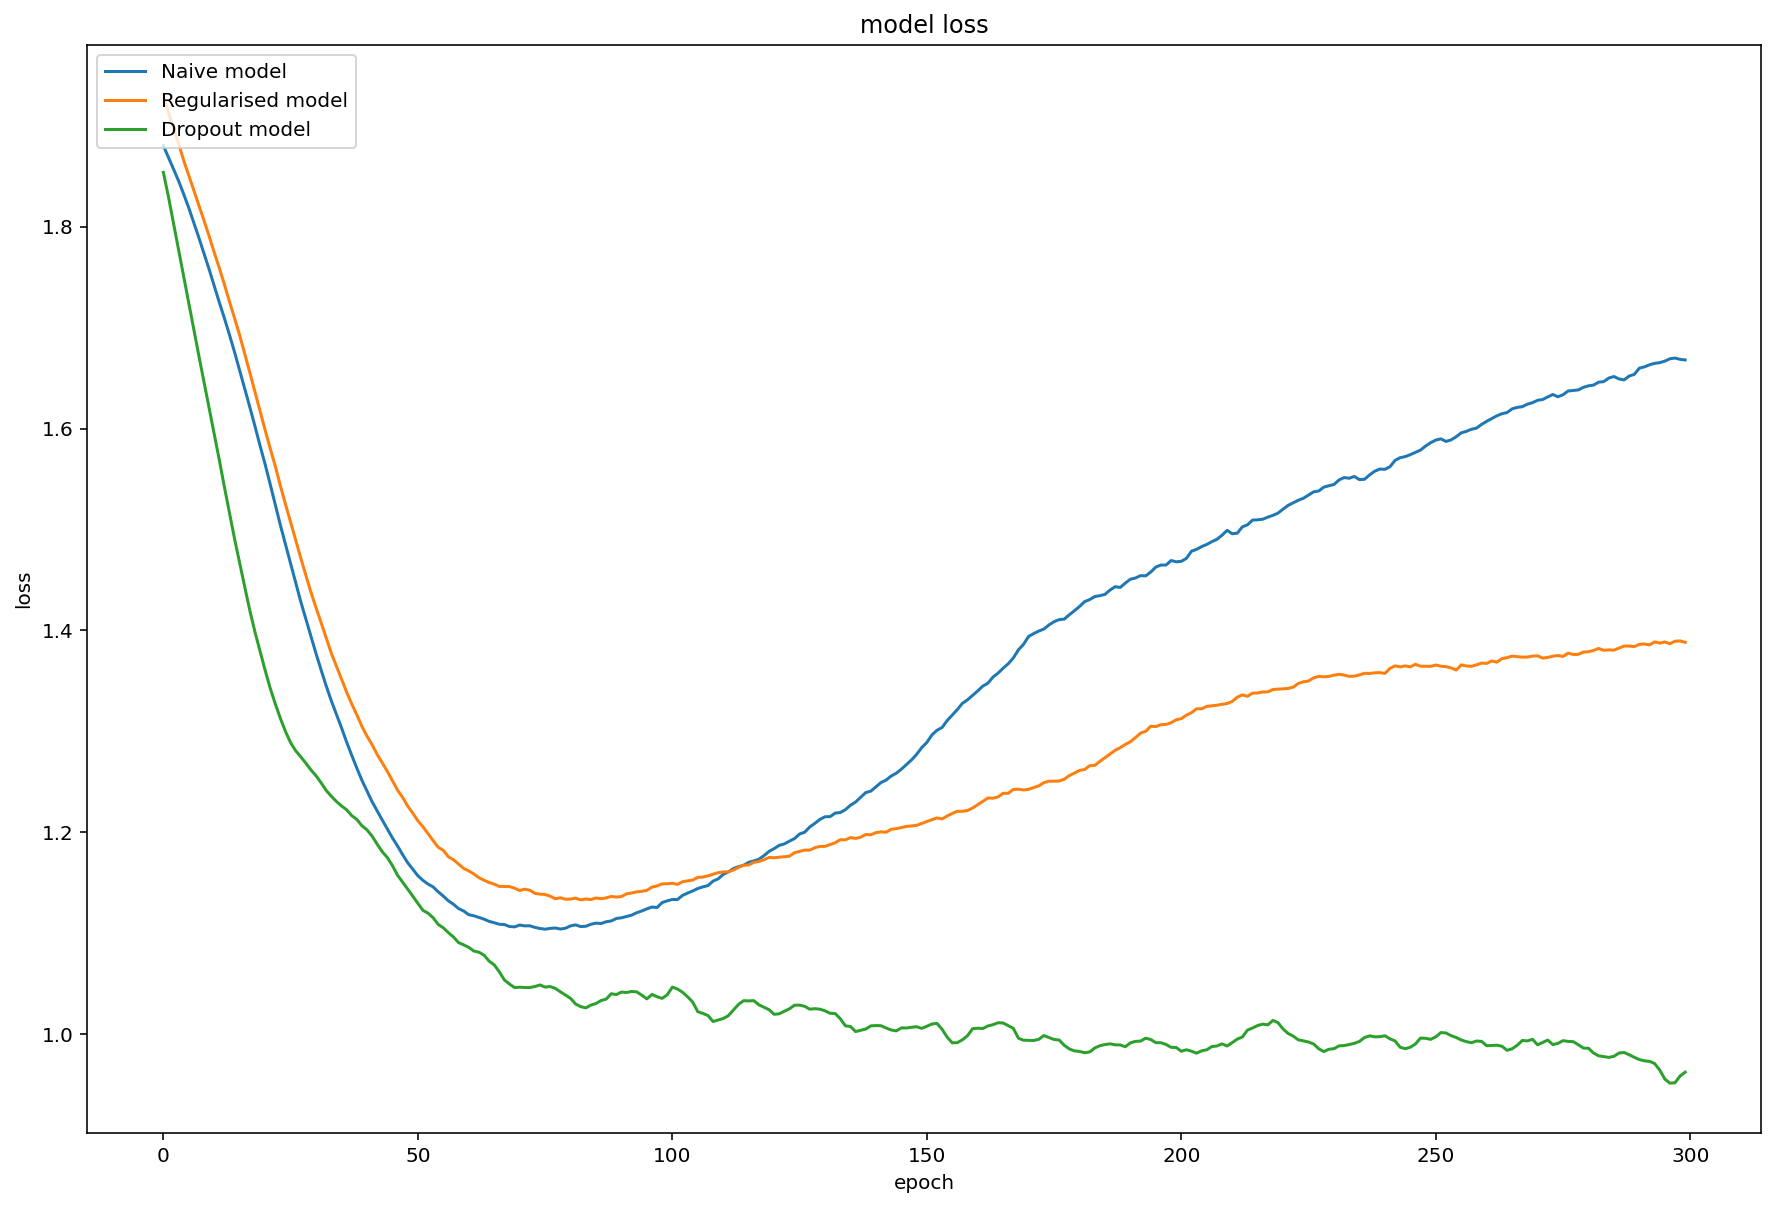

In [21]:
plt.figure(figsize=(15,10))
# summarize history for loss
#plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history_pen.history['val_loss'])
plt.plot(history_drp.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Naive model', 'Regularised model', 'Dropout model'], loc='upper left')
plt.show()

## Another regularisation technique: Early Stopping

Have a look at the plot above. All the losses are decresing until aroung epoch $75$. Stopping at this step (_i.e._ in general reducing epochs) might reduce overfitting issues.

![](https://miro.medium.com/max/1400/1*2zD7wwIwhIrHdr8F4urF2w.png)

## What you should remember
- Very deep "plain" networks don't work in practice because they are hard to train due to overfit and misprediction problems. 
- Fighting overfit means keeping a bit less attention on training set, to generalise better on new data.

### References  

- A quite nice and not too technical reading is [this medium blog post](https://towardsdatascience.com/handling-overfitting-in-deep-learning-models-c760ee047c6e)
- Francois Chollet's GitHub repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
